In [1]:
import os 
import numpy as np
import keras
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPooling2D, Dropout, Activation
from keras.layers import Flatten, Dense, Activation
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [2]:
import keras
print(keras.__version__)


3.9.2


In [3]:
current_dir = os.getcwd()
train_dir = os.path.join(current_dir, 'DevanagariHandwrittenCharacterDataset/Train')
test_dir = os.path.join(current_dir, 'DevanagariHandwrittenCharacterDataset/Test')

train_datasets = os.listdir(train_dir)
test_datasets = os.listdir(test_dir)
print(test_datasets[24])
len(train_datasets)

character_32_patalosaw


46

In [4]:
train_dataset_count = 0
for i in train_datasets:
    data_path = os.path.join(train_dir, str(i))
    train_dataset_count += len(os.listdir(data_path))   
print(train_dataset_count)

test_dataset_count = 0
for i in test_datasets:
    data_path = os.path.join(test_dir, str(i))
    test_dataset_count += len(os.listdir(data_path))   
print(test_dataset_count)

78200
13800


In [5]:
batch_size = 32
img_rows, img_cols = 32,32
epochs = 100

In [6]:
# Load dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    image_size=(img_rows, img_cols),
    batch_size=batch_size,
    label_mode='categorical'  # one-hot encoded labels
)

Found 78200 files belonging to 46 classes.


In [7]:
test_dataset = image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    image_size=(img_rows, img_cols),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 13800 files belonging to 46 classes.


In [8]:
# Normalize and augment (replaces ImageDataGenerator)
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),  # same as rescale=1./255
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0, 0),  # optional alternative to fill_mode
])

# Apply augmentation to training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))  # normalize only

In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),activation='relu',input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=len(train_datasets), activation='softmax'))

C:\Users\Nitro\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,598 (639.05 KB)

 Trainable params: 163,598 (639.05 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                           patience=10,
                           verbose=1,
                           mode='max',
                           restore_best_weights=True
                          )
check_point = ModelCheckpoint(
    'Handwritten_OCR.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks=[check_point, early_stop]

In [12]:
optimizer = Adam(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [13]:
model.build(input_shape=(None, img_rows, img_cols, 1))

In [14]:
time1 = time.time()

history = model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=epochs,
    steps_per_epoch=train_dataset_count // batch_size,
    verbose=1,
    callbacks=callbacks
)

time2 = time.time()

print(f"Training time: {time2 - time1:.2f} seconds")

Epoch 1/100
2441/2443 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6676 - loss: 1.2321
Epoch 1: val_accuracy improved from -inf to 0.94493, saving model to Handwritten_OCR.keras
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 95s 38ms/step - accuracy: 0.6678 - loss: 1.2314 - val_accuracy: 0.9449 - val_loss: 0.1847
Epoch 2/100
   1/2443 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - accuracy: 0.8750 - loss: 0.3295

C:\Users\Nitro\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.94493
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.8750 - loss: 0.3295 - val_accuracy: 0.9437 - val_loss: 0.1857
Epoch 3/100
2439/2443 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9208 - loss: 0.2604
Epoch 3: val_accuracy improved from 0.94493 to 0.96594, saving model to Handwritten_OCR.keras
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9208 - loss: 0.2604 - val_accuracy: 0.9659 - val_loss: 0.1136
Epoch 4/100
   1/2443 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9583 - loss: 0.1877
Epoch 4: val_accuracy improved from 0.96594 to 0.96616, saving model to Handwritten_OCR.keras
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - accuracy: 0.9583 - loss: 0.1877 - val_accuracy: 0.9662 - val_loss: 0.1143
Epoch 5/100
2437/2443 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9457 - loss: 0.1749
Epoch 5: val_accuracy improved from 0.96616 to 0.97152, saving model to Handwritten_OCR.keras
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 23s 9m

In [15]:
print(f'{(time2 - time1)/60} mins')

8.900549209117889 mins


In [16]:

history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

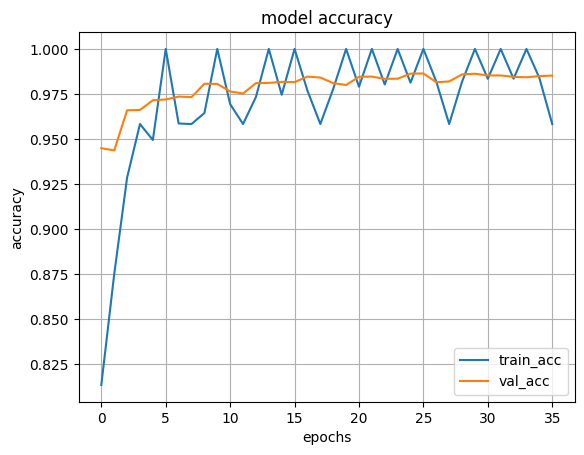

<Figure size 640x480 with 0 Axes>

In [17]:
#Accuracy plotting
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig('model_acc.png')

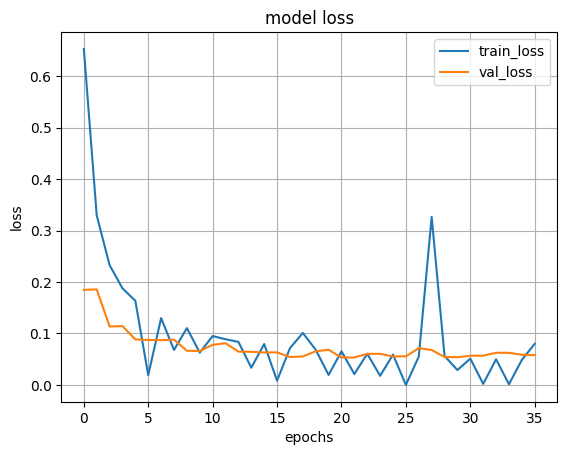

<Figure size 640x480 with 0 Axes>

In [18]:
#Loss plotting
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig('model_loss.png')